In [2]:
%%capture
!pip install wandb


In [3]:
import matplotlib.pyplot as plt
import os
import time

import tensorflow as tf
from tensorflow.keras import layers


In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) /127.5


In [7]:
# BUFFER_SIZE = 60000
# BATCH_SIZE = 256


In [44]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(config.BUFFER_SIZE).batch(config.BATCH_SIZE)


In [45]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


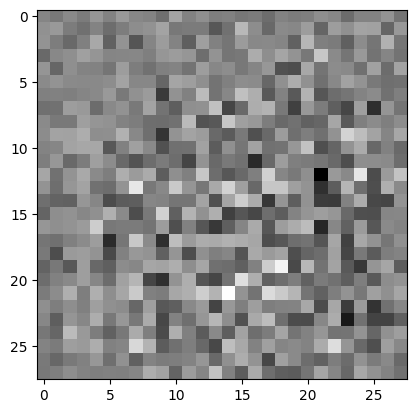

In [46]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [47]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [48]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[0.00095376]], shape=(1, 1), dtype=float32)


In [49]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [50]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [51]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [52]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [53]:
# EPOCHS = 1
# noise_dim = 100
# num_to_generate = 16

seed = tf.random.normal([config.num_to_generate, config.noise_dim])


In [54]:
@tf.function
def train_step(images):
    noise = tf.random.normal([config.BATCH_SIZE, config.noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [55]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      wandb.log({'Discriminator Loss': disc_loss, 'Generator Loss': gen_loss})

    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  generate_and_save_images(generator,
                           epochs,
                           seed)


In [56]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  img = 'image_at_epoch_{:04d}.png'.format(epoch)
  plt.savefig(img)
  plt.show()

  wandb.log({"Images": [wandb.Image(img, caption=f'Epoch {epoch}')]})


In [63]:
import wandb
wandb.login()
wandb.init(project='DCGAN', name='Experiment2')

config = wandb.config
config.BUFFER_SIZE = 60000
config.BATCH_SIZE = 128
config.EPOCHS = 20
config.noise_dim = 100
config.num_to_generate = 16

wandb.config.update(config)


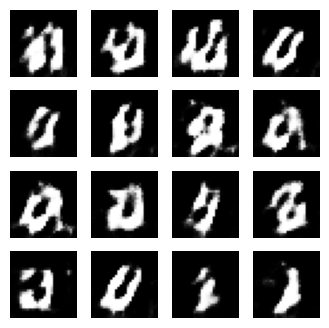

Time for epoch 1 is 11.207691431045532 sec


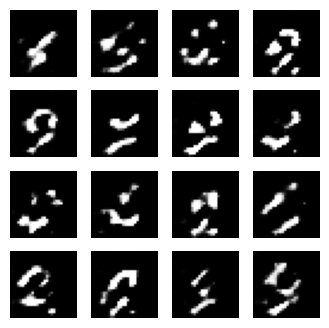

Time for epoch 2 is 21.790820360183716 sec


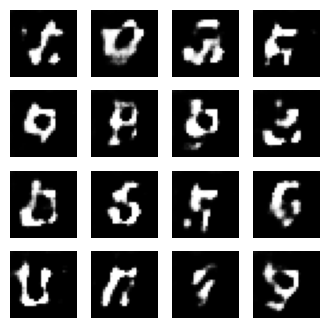

Time for epoch 3 is 11.167707204818726 sec


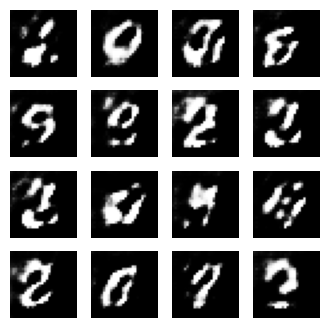

Time for epoch 4 is 11.123348712921143 sec


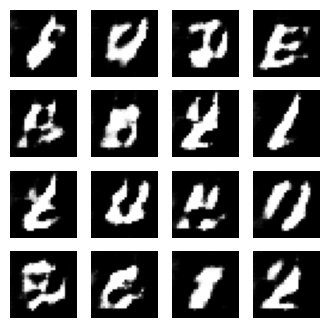

Time for epoch 5 is 11.158768892288208 sec


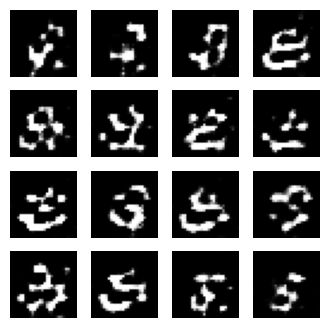

Time for epoch 6 is 21.347453832626343 sec


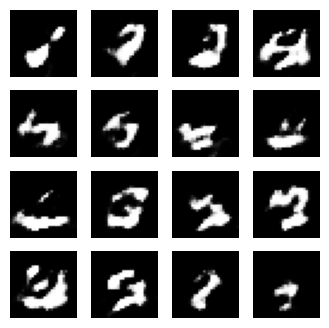

Time for epoch 7 is 11.775232315063477 sec


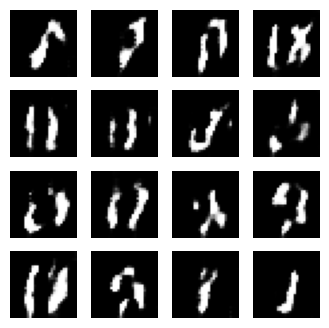

Time for epoch 8 is 11.257932424545288 sec


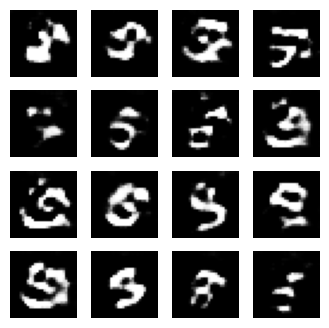

Time for epoch 9 is 21.08602261543274 sec


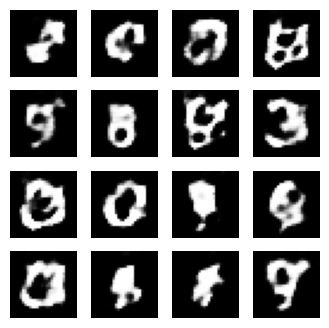

Time for epoch 10 is 11.336775302886963 sec


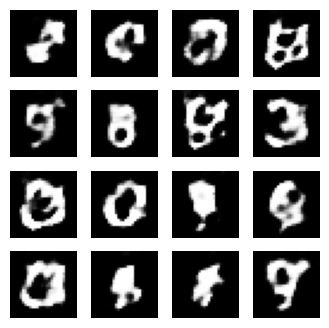

Discriminator Loss,▄▅▆▅▄▆▇▄▅▅▄▇▄▅█▄▄▄▅▅▅▂▄▇▄▄▃▅▅▃▄▄▃▃▅▁▅▄▄▆
Generator Loss,▄▃▂▃▃▂▁▃▃▃▃▁▄▃▁▄▄▄▄▃▄▆▅▂▅▅▆▃▄▅▅▄▄▆▄█▄▅▄▃
Discriminator Loss,0.82803
Generator Loss,1.26976


In [64]:
train(train_dataset, config.EPOCHS)
wandb.finish()
